In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measure = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
first_row = session.query(Measure).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b63dafc790>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [10]:
for row in session.query(Measure.station, Measure.date).limit(15).all():
    print(row)


('USC00519397', '2010-01-01')
('USC00519397', '2010-01-02')
('USC00519397', '2010-01-03')
('USC00519397', '2010-01-04')
('USC00519397', '2010-01-06')
('USC00519397', '2010-01-07')
('USC00519397', '2010-01-08')
('USC00519397', '2010-01-09')
('USC00519397', '2010-01-10')
('USC00519397', '2010-01-11')
('USC00519397', '2010-01-12')
('USC00519397', '2010-01-14')
('USC00519397', '2010-01-15')
('USC00519397', '2010-01-16')
('USC00519397', '2010-01-17')


In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b6410e1dc0>,
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measure.date).order_by(Measure.date.desc()).first()
most_recent_date

('2017-08-23',)

In [13]:
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [14]:
current = dt.date(2017, 8, 23)
current

datetime.date(2017, 8, 23)

In [43]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

current = dt.date(2017, 8, 23)
current
year_ago = current - dt.timedelta(days=365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores

last_year_prcp = session.query(Measure.date, Measure.prcp).\
    filter(Measure.date >= year_ago).\
    filter(Measure.date <= current).\
    order_by(Measure.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

rain_df = pd.DataFrame(last_year_prcp)
clean_rain_df = rain_df.dropna(how='any')
clean_rain_df


2016-08-23


,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79
...,...,...
2225,2017-08-22,0.50
2226,2017-08-23,0.00
2227,2017-08-23,0.00
2228,2017-08-23,0.08


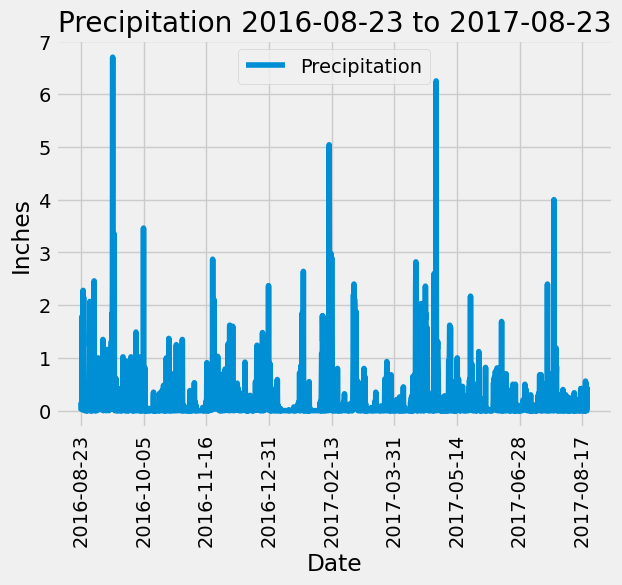

In [44]:
clean_rain_df.plot('date', 'prcp')
font = {'weight': 'bold', 'size': '10'}
# plt.figure(figsize=(8,7))
plt.style.use('fivethirtyeight')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title(f'Precipitation {year_ago} to {current}')
plt.legend(["Precipitation"],loc='best')
plt.xticks(rotation="vertical")
# plt.tight_layout()
# plt.savefig("./precipitation_by_dates.png")
plt.show()

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
clean_rain_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset
station_number = session.query(Station.station).count()
station_number
  

9

In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_activity = session.query(Measure.id, Station.name, Measure.station).\
    filter(Measure.station == Station.station).\
    group_by(Measure.station).\
    order_by(Measure.id.desc()).all()
   
for x in station_activity:
    print(x)

(16939, 'MANOA LYON ARBO 785.2, HI US', 'USC00516128')
(14960, 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918')
(12188, 'WAIHEE 837.5, HI US', 'USC00519281')
(9519, 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523')
(9008, 'UPPER WAHIAWA 874.3, HI US', 'USC00518838')
(7636, 'PEARL CITY, HI US', 'USC00517948')
(5434, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830')
(2725, 'KANEOHE 838.1, HI US', 'USC00513117')
(1, 'WAIKIKI 717.2, HI US', 'USC00519397')


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station = session.query(Station.name, func.min(Measure.prcp)\
    , func.max(Measure.prcp)\
    , func.round(func.avg(Measure.tobs),2)).\
    filter(Measure.station == Station.station).\
    filter(Measure.station == 'USC00516128').all()

most_active_station

[('MANOA LYON ARBO 785.2, HI US', 0.0, 8.06, 70.92)]

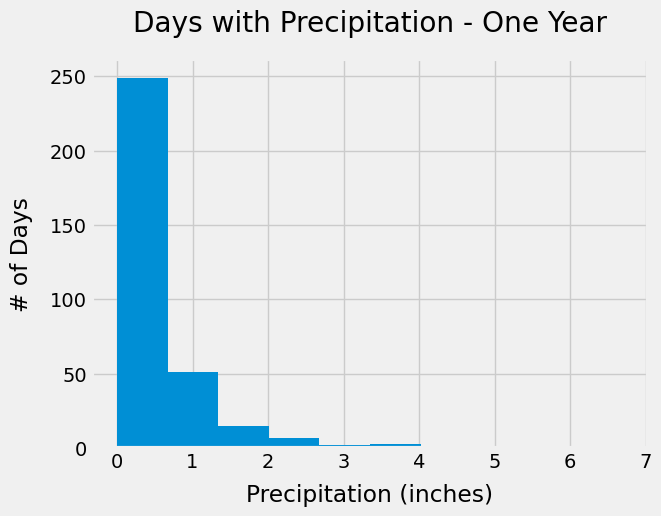

NormaltestResult(statistic=31.927570991796628, pvalue=1.1668527359411976e-07)
NormaltestResult(statistic=288.229963769274, pvalue=2.5802311139911115e-63)


In [42]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station_temp = session.query(Station.name, Measure.date, Measure.prcp).\
    filter(Measure.station == Station.station).\
    filter(Measure.station == 'USC00516128').\
    filter(Measure.date >= year_ago).\
    filter(Measure.date <= current).\
    filter(Measure.prcp != 'None').\
    order_by(Measure.date).all()

# Save query results to a dataframe

df = pd.DataFrame(most_active_station_temp)

# Plot results as a histogram

import scipy.stats as st
plt.hist(df['prcp'])
plt.style.use('fivethirtyeight')
plt.title('Days with Precipitation - One Year', pad=20)
plt.xlabel('Precipitation (inches)', labelpad=8)
plt.ylabel('# of Days', labelpad=12)
plt.show()
print(st.normaltest(df['prcp'].sample(50)))
print(st.normaltest(df['prcp'].sample(300)))



# Close session

In [41]:
# Close Session
session.close()